# Sentiment Analysis using Bag of Words

In [1]:
# Imports
from keras.datasets import imdb
import nltk
#nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, sent_tokenize, pos_tag
#nltk.download('punkt')
import numpy as np
import pandas as pd
import re
from sklearn.tree import DecisionTreeClassifier 
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


### Load the data

In [2]:
# split the data set into training and testing target-data
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data()
# get all the words already tokenized(remember that the words are unique, each having an ID) -> returns a dictionary
index = imdb.get_word_index()

# reverse key-value pair in dictionary
reverse_index = dict([(value, key) for (key, value) in index.items()])

### Decode all sentences  
The dataset loaded from Keras has 50000 instances divided into training and testing set. We want to put them back together and also retrieve the original sentences.

In [3]:
# Concatenate training and testing sets
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)

# Decode all the sentences: extract all the sentences from training data and testing data decoded
decoded_sentences = []
for x in range(len(data)):
    decoded_sentences.append(" ".join([reverse_index.get(i - 3, "#") for i in data[x]]))

In [4]:
# Clean the data
decoded_sentences_cleaned = []

for sen in range(0, len(decoded_sentences)):
    document = (decoded_sentences[sen])
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    document = re.sub(r"('s)", ' ', document)
    document = re.sub(r"(' )", ' ', document)
    document = re.sub(r"( ' )", ' ', document)
    document = re.sub(r"( ')", ' ', document)
    
    #remove numbers
    document = re.sub(r"[0-9]+", ' ', document)
    
    document = re.sub(r"(#)", ' ', document)
    document = re.sub(r"(\x96)", ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    decoded_sentences_cleaned.append(document)

In [5]:
# Lemmatizer
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

decoded_sentences_lemmatized = []

for sen in range(0, len(decoded_sentences_cleaned)):
    document = (decoded_sentences_cleaned[sen])
    
    #tag the sentence first
    #document = document.split()
    #pos_map = {'J': 'a', 'N': 'n', 'R': 'r', 'V': 'v'}
    #pos_tags = pos_tag(document)
    #document = [lemmatiser.lemmatize(t.lower(), pos=pos_map.get(p[0], 'v')) for t, p in pos_tags]
    #document = ' '.join(document)

    document = document.split()
    document = [lemmatiser.lemmatize(word, 'r') for word in document]
    document = ' '.join(document)
   
    decoded_sentences_lemmatized.append(document)

In [6]:
documents = decoded_sentences_lemmatized

# # Free up memory
# del decoded_sentences_cleaned
# del decoded_sentences_lemmatized
# del training_data
# del training_targets
# del testing_data
# del testing_targets

### Vectorize sentences  
Sentences can be either vectorized using CountVectorizer() which are bag of words or TfidfTransformer().  
BOW  assigns a score to a word based on its occurrence in a particular document. It doesn't take into account the fact that the word might also be having a high frequency of occurrence in other documents as well.  
TFIDF resolves this issue by multiplying the term frequency of a word by the inverse document frequency. The TF stands for "Term Frequency" while IDF stands for "Inverse Document Frequency".  
In simple words TIDF would diminish the weight (importance) of words appeared in many documents in common, considered them incapable of discerning the documents, rather than simply counting the frequency of words as CountVectorizer does.

In [7]:
# define stopwords
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['br'])

In [8]:
# vectorize all
vectorizer = CountVectorizer(max_features=1500, max_df=0.7, stop_words=stopwords)
X = vectorizer.fit_transform(documents).toarray()
#print(vectorizer.get_feature_names())

In [9]:
# creating data frame and appending labels so to extract a normal distribution
labels = pd.DataFrame(targets)
dataset_frame = pd.DataFrame(data=X)
dataset_frame['Class'] = labels

#Name the columns
#vocab = vectorizer.get_feature_names()
#vocab.append('Class')
#dataset_frame.columns = [vocab[:]]
#dataset_frame

In [10]:
# change the number of parameters involved from here
bound = 25000
reviews_negative = dataset_frame[dataset_frame['Class'] == 0].iloc[:bound,:]
reviews_positive = dataset_frame[dataset_frame['Class'] == 1].iloc[:bound,:]
#extract a normal distribution according to an upper bound
reviews = reviews_negative.append(reviews_positive, ignore_index = True) 



In [89]:
#train
X_train, X_test, y_train, y_test = train_test_split(reviews.iloc[:,:-1],reviews.iloc[:,(len(reviews.columns) -1):], test_size=0.2, random_state=0, shuffle=True)
# Decision tree
tree = DecisionTreeClassifier(max_depth=13,criterion = 'entropy').fit(X_train,y_train)#The accuracy is then calculated through the score function offered by sklearn
#print("The prediction accuracy is: ",tree.score(X_test,y_test)*100,"%")

### Printing Decision Matrix and scores  
Notice that the structure of the decision matrix is as follows:  
TN  FP  
FN TP  

High precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

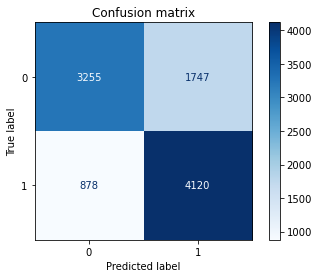

The prediction accuracy is:  74.0 %
The prediction f1-score is:  76.0 %
Precision: 0.70
Recall: 0.82


In [90]:
# conf matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


titles_options = [("Confusion matrix", None)]
class_names = ['Negative', 'Positive']
for title, normalize in titles_options:
    disp = plot_confusion_matrix(tree, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    #print(title)
    #print(disp.confusion_matrix)

plt.show()

# metrics
y_pred = tree.predict(X_test)
#print(confusion_matrix(y_test,y_pred))
print("The prediction accuracy is: ", round(accuracy_score(y_test, y_pred) * 100), "%")
print("The prediction f1-score is: ", round(f1_score(y_test, y_pred) * 100), "%")

print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))

### Print Decision Tree  
The proposed decision tree is quote large. To visualize it properly either prune the tree changing the parameters in the DecisionClassifier or save the image and open it on your computer zooming in.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.715921 to fit



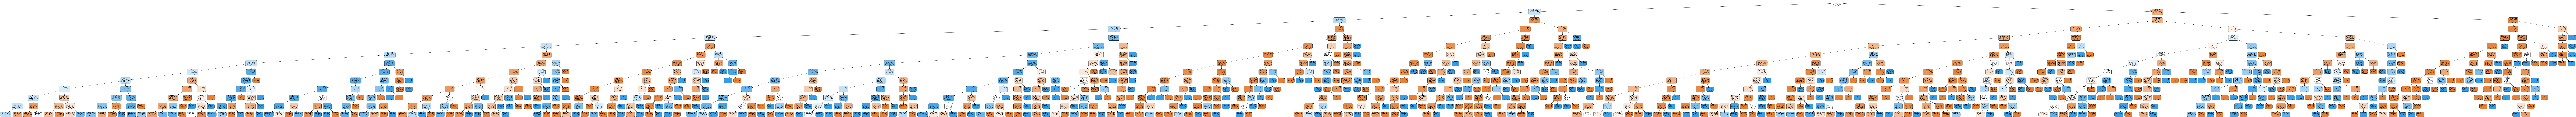

In [91]:
import io
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = io.StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                class_names=True,
                feature_names= vectorizer.get_feature_names(),
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())



In [82]:
# lookup words in the vectorizer by using their index number
#print(vectorizer.get_feature_names()[102])

bad


Average of the list = 76.0 %


Text(0.5, 1.0, 'Average score: 76.0 %')

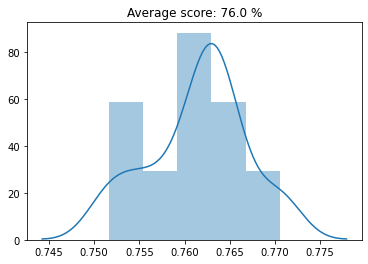

In [34]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
# try with k folds
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(max_depth=13,criterion = 'entropy', random_state=0)
k_folds = cross_val_score(clf, reviews.iloc[:,:-1], reviews.iloc[:,(len(reviews.columns) -1):], cv=9, scoring= make_scorer(f1_score))

# Python program to get average of a list 
def Average(lst): 
    return sum(lst) / len(lst) 
  
# Driver Code 
average = Average(k_folds) 
  
# Printing average of the list 
print("Average of the list =", round(average, 2) * 100 , "%")

import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(k_folds)
plt.title('Average score: {} %'.format(round(np.mean(k_folds) * 100),2))

#### References  
https://stackabuse.com/text-classification-with-python-and-scikit-learn/
https://www.kaggle.com/kyen89/1-sentiment-analysis-tf-idf
https://stackabuse.com/using-regex-for-text-manipulation-in-python/
https://builtin.com/data-science/how-build-neural-network-keras